In [2]:
import pandas as pd
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/result.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.head()

,_id,topic,heading,summary,date_published,content,tags
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""Create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi..."
1,5ef0d2b6d83b3587cb500eca,NaN,"[""‘Sino-India ties will deteriorate further’: ...","[""Other Videos""]",NaN,NaN,NaN
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""Over the past dozen years India has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo..."
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""DRAW THE LINE Policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""For MPs to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN


In [7]:
df.shape

(114, 7)

In [8]:
df.isnull().sum()

_id                0
topic             10
heading            0
summary            1
date_published    10
content           11
tags              20
dtype: int64

In [26]:
df.dropna(subset=['content'], inplace = True)
df.dropna(subset=['summary'], inplace = True)

In [27]:
df.shape

(103, 8)

In [28]:
df.groupby('topic').heading.count()

topic
["analysis"]               6
["art-and-culture"]        1
["bollywood"]              5
["business"]               6
["columns"]                2
["cricket"]                3
["delhi"]                  4
["editorials"]             4
["education"]              9
["fashion-and-trends"]     4
["fitness"]                1
["football"]               2
["india"]                 12
["it-s-viral"]             8
["more-lifestyle"]         1
["mumbai"]                 7
["music"]                  1
["opinion"]                2
["other-sports"]           2
["regional-movies"]        1
["tennis"]                 1
["travel"]                 1
["tv"]                     8
["world"]                  8
Name: heading, dtype: int64

In [16]:
df['len_article'] = df.content.str.len()
df.head()

,_id,topic,heading,summary,date_published,content,tags,len_article
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""Create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi...",5820
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""Over the past dozen years India has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo...",3797
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""DRAW THE LINE Policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN,5583
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""For MPs to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN,1732
5,5ef0d2bed83b3587cb500ece,"[""columns""]","[""How China has overplayed its hand, writes Ba...","[""Beijing’s belligerence reflects a familiar h...","[""Updated: Jun 22, 2020 19:31 IST""]","[""Almost 2,500 years ago, Greek historian, Thu...","[""CHINA"",""India""]",5447


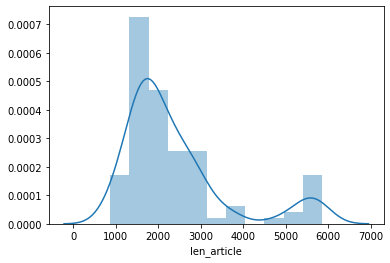

In [17]:
sns.distplot(df.len_article)

In [37]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import re, spacy, gensim
#nltk.download('punkt')

In [43]:
#sent_tokenized = [sent for sent in nltk.sent_tokenize("")
# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
#word_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]
#filtered = [word for word in word_tokenized if re.search('[a-zA-Z]', word)]

df.summary = df.summary.str.lower()
df['tokenized_summary'] = df.summary.apply(lambda x: word_tokenize(x))

In [44]:
df.head()

,_id,topic,heading,summary,date_published,content,tags,len_article,tokenized_summary
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi...",5820,"[[, ``, create, a, legal, regime, that, allows..."
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""over the past dozen years india has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo...",3797,"[[, ``, over, the, past, dozen, years, india, ..."
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""draw the line policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN,5583,"[[, ``, draw, the, line, policing, the, border..."
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""for mps to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN,1732,"[[, ``, for, mps, to, take, it, up, ,, expand,..."
5,5ef0d2bed83b3587cb500ece,"[""columns""]","[""How China has overplayed its hand, writes Ba...","[""beijing’s belligerence reflects a familiar h...","[""Updated: Jun 22, 2020 19:31 IST""]","[""Almost 2,500 years ago, Greek historian, Thu...","[""CHINA"",""India""]",5447,"[[, ``, beijing, ’, s, belligerence, reflects,..."


In [52]:
stops = list(set(stopwords.words())) + list(punctuation) + ['s', "'", 't', 'and', '"', 'a', 'or', '/', 'in',
                                                                    'for', '&', '-', "''"]

In [57]:
#nltk.download('stop_words')
def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops
df['tokenized_summary'] = df['tokenized_summary'].apply(lambda x: remove_stops(x))

In [58]:
df.head()


,_id,topic,heading,summary,date_published,content,tags,len_article,tokenized_summary
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi...",5820,"[``, create, legal, regime, allows, access, sa..."
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""over the past dozen years india has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo...",3797,"[``, past, dozen, years, india, closed, gap, c..."
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""draw the line policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN,5583,"[``, draw, line, policing, borders, preventing..."
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""for mps to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN,1732,"[``, mps, expand, ambit, cluster, villages, pr..."
5,5ef0d2bed83b3587cb500ece,"[""columns""]","[""How China has overplayed its hand, writes Ba...","[""beijing’s belligerence reflects a familiar h...","[""Updated: Jun 22, 2020 19:31 IST""]","[""Almost 2,500 years ago, Greek historian, Thu...","[""CHINA"",""India""]",5447,"[``, beijing, belligerence, reflects, familiar..."


In [59]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [91]:
#nltk.download('wordnet')
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized
df['tokenized_summary'] = df['tokenized_summary'].apply(lemmatize_text)
df['tokenized_summary'] = df['tokenized_summary'].apply(lambda x: ' '.join(x))
df.head()

,_id,topic,heading,summary,date_published,content,tags,len_article,tokenized_summary
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi...",5820,`` create legal regime allows access safety sh...
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""over the past dozen years india has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo...",3797,`` past dozen year india closed gap china mili...
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""draw the line policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN,5583,`` draw line policing border preventing intrus...
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""for mps to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN,1732,`` mp expand ambit cluster village provide fund
5,5ef0d2bed83b3587cb500ece,"[""columns""]","[""How China has overplayed its hand, writes Ba...","[""beijing’s belligerence reflects a familiar h...","[""Updated: Jun 22, 2020 19:31 IST""]","[""Almost 2,500 years ago, Greek historian, Thu...","[""CHINA"",""India""]",5447,`` beijing belligerence reflects familiar hist...


In [62]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.tokenize import RegexpTokenizer

In [63]:
#stemmer = PorterStemmer()
#def stem_list(lst):
    #stemmed_list = []
    #for i in lst:
   #     stemmed_list.append(stemmer.stem(i))
  #  stem_string = ' '.join(stemmed_list)
 #   return stem_string

#import ast
#df['stemmed'] = df["first_100_no_stops"].apply(lambda x: ast.literal_eval(x))
#df['stemmed'] = df["stemmed"].apply(lambda x: stem_list(x))

#drop specific duplicate rows
#df = df[~df['stemmed'].str.contains("archiveteam.org contain", case=False)]

In [93]:
#create list of stemmed document strings
#documents = df['stemmed'].to_list()
documents = df['tokenized_summary'].to_list()

In [66]:
def vectorize_texts(list_of_strings):
    print('Performing vectorization and TF/IDF transformation on texts...')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(list_of_strings)
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf

In [67]:
def cluster_texts(num_clusters, tfidf):
    #perform kmeans clustering for range of clusters
    print('Beginning KMeans Clustering, number of clusters = ', num_clusters, '\n') 
    km = KMeans(n_clusters=num_clusters, max_iter = 100, verbose = 2, n_init = 1).fit(tfidf)
    return km

In [94]:
documents_vectorized = vectorize_texts(documents)

Performing vectorization and TF/IDF transformation on texts...


In [95]:
kmeans3 = cluster_texts(3, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  3 

Initialization complete
Iteration  0, inertia 192.589
Iteration  1, inertia 97.020
Iteration  2, inertia 97.013
Converged at iteration 2: center shift 0.000000e+00 within tolerance 8.464569e-08


In [97]:
kmeans4 = cluster_texts(4, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  4 

Initialization complete
Iteration  0, inertia 98.000
Iteration  1, inertia 96.421
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.464569e-08


In [101]:
kmeans5 = cluster_texts(5, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  5 

Initialization complete
Iteration  0, inertia 97.000
Iteration  1, inertia 95.433
Converged at iteration 1: center shift 0.000000e+00 within tolerance 8.464569e-08


In [ ]:
#kmeans6 = cluster_texts(6, documents_vectorized)

In [99]:
#import pickle
#save the best model for further use

#pickle.dump(kmeans3, open("../Models/kmeans3.pkl", "wb"))

#load back in kmeans12 model
#kmeans = pickle.load(open("kmeans12.pkl", "rb"))

In [109]:
kmean_df = pd.DataFrame(pd.np.empty((0, 3)))
kmean_df.columns = ['kmeans3', 'kmeans4', 'kmeans5']
kmean_df['kmeans3'] = kmeans3.labels_
kmean_df['tokenized_summary'] = df['tokenized_summary']
print(df.shape)
print(kmean_df.shape)

(103, 9)
(103, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


In [111]:
kmean_df['kmeans3'].value_counts()

1    47
2    31
0    25
Name: kmeans3, dtype: int64

[Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')]

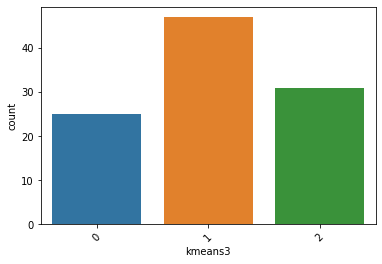

In [112]:
ax = sns.countplot(x= 'kmeans3', data=kmean_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
#function to find the most common words within each cluster
#def get_most_common_words(df, df_column, num_words):
    #common_words = []
    #for i in range(0,12):
        #common = Counter(" ".join(df.loc[df_column == i]['tokenized_summary']).split()).most_common(num_words)
        #for j in common:
        #    dict_ = {}
       #     dict_['cluster'] = i
      #      dict_['word'] = j[0]
     #       common_words.append(dict_)
            
    #return common_words

In [113]:
kmean_df

,kmeans3,kmeans4,kmeans5,tokenized_summary
0,0,NaN,NaN,`` create legal regime allows access safety sh...
1,1,NaN,NaN,NaN
2,1,NaN,NaN,`` past dozen year india closed gap china mili...
3,1,NaN,NaN,`` draw line policing border preventing intrus...
4,1,NaN,NaN,`` mp expand ambit cluster village provide fund
...,...,...,...,...
98,1,NaN,NaN,`` \n google search trend month june searched ...
99,1,NaN,NaN,`` explaining method followed teaching educati...
100,2,NaN,NaN,`` punjab haryana high court tuesday allowed p...
101,2,NaN,NaN,`` according official order jagdish upasane di...


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import calinski_harabaz_score

from collections import Counter